In [1]:
import matplotlib.pyplot as plt 
import time 
from tqdm import tqdm 
import random 
import torch 
from torch.utils.data import random_split, DataLoader, Dataset
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.cluster import KMeans
from linear_operator.settings import max_cholesky_size

import sys 
sys.path.append("../")
from gp.util import dynamic_instantiation, flatten_dict, unflatten_dict, flatten_dataset, split_dataset, filter_param, heatmap

# System/Library imports
from typing import *

# Common data science imports
import numpy as np
import torch

# Gpytorch and linear_operator
import gpytorch 
import gpytorch.constraints
from gpytorch.kernels import ScaleKernel
import linear_operator
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Our imports
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg



c:\Users\chris\anaconda3\envs\softgp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Soft GP testing profiling/tuning boilerplate
its recommend to collapse all functions with Ctrl/Cmnd +k +0 

### SoftGP baseline implementation 
---


In [2]:
class SoftGP_baseline(torch.nn.Module):
    def __init__(
        self,
        kernel: Callable,
        inducing_points: torch.Tensor,
        noise=1e-3,
        learn_noise=False,
        use_scale=False,
        device="cpu",
        dtype=torch.float32,
        solver="solve",
        max_cg_iter=50,
        cg_tolerance=0.5,
        mll_approx="hutchinson",
        fit_chunk_size=1024,
        use_qr=False,
    ) -> None:
        # Argument checking 
        methods = ["solve", "cholesky", "cg"]
        if not solver in methods:
            raise ValueError(f"Method {solver} should be in {methods} ...")
        
        # Check devices
        devices = ["cpu"]
        if torch.cuda.is_available():
            devices += ["cuda"]
            for i in range(torch.cuda.device_count()):
                devices += [f"cuda:{i}"]
        if not device in devices:
            raise ValueError(f"Device {device} should be in {devices} ...")

        # Create torch module
        super(SoftGP_baseline, self).__init__()

        # Misc
        self.device = device
        self.dtype = dtype
        
        # Mll approximation settings
        self.solve_method = solver
        self.mll_approx = mll_approx

        # Fit settings
        self.use_qr = use_qr
        self.fit_chunk_size = fit_chunk_size

        # Noise
        self.noise_constraint = gpytorch.constraints.Positive()
        noise = torch.tensor([noise], dtype=self.dtype, device=self.device)
        noise = self.noise_constraint.inverse_transform(noise)
        if learn_noise:
            self.register_parameter("raw_noise", torch.nn.Parameter(noise))
        else:
            self.raw_noise = noise

        # Kernel
        self.use_scale = use_scale
        if use_scale:
            self.kernel = ScaleKernel(kernel).to(self.device)
        else:
            self.kernel = kernel.to(self.device)

        # Inducing points
        self.register_parameter("inducing_points", torch.nn.Parameter(inducing_points))

        # Interpolation
        def softmax_interp(X: torch.Tensor, sigma_values: torch.Tensor) -> torch.Tensor:
            distances = torch.linalg.vector_norm(X - sigma_values, ord=2, dim=-1)
            softmax_distances = torch.softmax(-distances, dim=-1)
            return softmax_distances
        self.interp = softmax_interp
        
        # Fit artifacts
        self.alpha = None
        self.K_zz_alpha = None

        # CG solver params
        self.max_cg_iter = max_cg_iter
        self.cg_tol = cg_tolerance
        self.x0 = None
        
    # -----------------------------------------------------
    # Soft GP Helpers
    # -----------------------------------------------------
    
    @property
    def noise(self):
        return self.noise_constraint.transform(self.raw_noise)

    def get_lengthscale(self) -> float:
        if self.use_scale:
            return self.kernel.base_kernel.lengthscale.cpu()
        else:
            return self.kernel.lengthscale.cpu()
        
    def get_outputscale(self) -> float:
        if self.use_scale:
            return self.kernel.outputscale.cpu()
        else:
            return 1.

    def _mk_cov(self, z: torch.Tensor) -> torch.Tensor:
        return self.kernel(z, z).evaluate()
    
    def _interp(self, x: torch.Tensor) -> torch.Tensor:
        x_expanded = x.unsqueeze(1).expand(-1, self.inducing_points.shape[0], -1)
        W_xz = self.interp(x_expanded, self.inducing_points)
        return W_xz

    # -----------------------------------------------------
    # Linear solver
    # -----------------------------------------------------

    def _solve_system(
        self,
        kxx: linear_operator.operators.LinearOperator,
        full_rhs: torch.Tensor,
        x0: torch.Tensor = None,
        forwards_matmul: Callable = None,
        precond: torch.Tensor = None,
        return_pinv: bool = False,
    ) -> torch.Tensor:
        use_pinv = False
        with torch.no_grad():
            try:
                if self.solve_method == "solve":
                    solve = torch.linalg.solve(kxx, full_rhs)
                elif self.solve_method == "cholesky":
                    L = torch.linalg.cholesky(kxx)
                    solve = torch.cholesky_solve(full_rhs, L)
                elif self.solve_method == "cg":
                    # Source: https://github.com/AndPotap/halfpres_gps/blob/main/mlls/mixedpresmll.py
                    solve = linear_cg(
                        forwards_matmul,
                        full_rhs,
                        max_iter=self.max_cg_iter,
                        tolerance=self.cg_tol,
                        initial_guess=x0,
                        preconditioner=precond,
                    )
                else:
                    raise ValueError(f"Unknown method: {self.solve_method}")
            except RuntimeError as e:
                print("Fallback to pseudoinverse: ", str(e))
                solve = torch.linalg.pinv(kxx.evaluate()) @ full_rhs
                use_pinv = True

        # Apply torch.nan_to_num to handle NaNs from percision limits 
        solve = torch.nan_to_num(solve)
        return (solve, use_pinv) if return_pinv else solve

    # -----------------------------------------------------
    # Marginal Log Likelihood
    # -----------------------------------------------------

    def mll(self, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Compute the marginal log likelihood of a soft GP:
            
            log p(y) = log N(y | mu_x, Q_xx)

            where
                mu_X: mean of soft GP
                Q_XX = W_xz K_zz W_zx

        Args:
            X (torch.Tensor): B x D tensor of inputs where each row is a point.
            y (torch.Tensor): B tensor of targets.

        Returns:
            torch.Tensor:  log p(y)
        """        
        # Construct covariance matrix components
        K_zz = self._mk_cov(self.inducing_points)
        W_xz = self._interp(X)
        
        if self.mll_approx == "exact":
            # [Note]: Compute MLL with a multivariate normal. Unstable for float.
            # 1. mean: 0
            mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
            # 2. covariance: Q_xx = (W_xz L) (L^T W_xz) + noise I  where K_zz = L L^T
            L = psd_safe_cholesky(K_zz)
            LK = (W_xz @ L).to(device=self.device)
            cov_diag = self.noise * torch.ones(len(X), dtype=self.dtype, device=self.device)

            # 3. N(mu, Q_xx)
            normal_dist = torch.distributions.lowrank_multivariate_normal.LowRankMultivariateNormal(mean, LK, cov_diag, validate_args=None)
            
            # 4. log N(y | mu, Q_xx)
            return normal_dist.log_prob(y)
        elif self.mll_approx == "hutchinson":
            # [Note]: Compute MLL with Hutchinson's trace estimator
            # 1. mean: 0
            mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
            # 2. covariance: Q_xx = W_xz K_zz K_zx + noise I
            cov_mat = W_xz @ K_zz @ W_xz.T 
            cov_mat += torch.eye(cov_mat.shape[1], dtype=self.dtype, device=self.device) * self.noise

            # 3. log N(y | mu, Q_xx) \appox 
            hutchinson_mll = HutchinsonPseudoLoss(self, num_trace_samples=10)
            return hutchinson_mll(mean, cov_mat, y)
        else:
            raise ValueError(f"Unknown MLL approximation method: {self.mll_approx}")
        
    # -----------------------------------------------------
    # Fit
    # -----------------------------------------------------

    def _direct_solve_fit(self, M, N, X, y, K_zz):
        # Construct A and b for linear solve
        #   A = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)
        #   b = (hat{K}_zx @ noise^{-1}) y
        if X.shape[0] * X.shape[1] <= 32768:
            # Case: "small" X
            # Form estimate \hat{K}_xz ~= W_xz K_zz
            W_xz = self._interp(X)
            hat_K_xz = W_xz @ K_zz
            hat_K_zx = hat_K_xz.T
            
            # Form A and b
            Lambda_inv_diag = (1 / self.noise) * torch.ones(N, dtype=self.dtype).to(self.device)
            A = K_zz + hat_K_zx @ (Lambda_inv_diag.unsqueeze(1) * hat_K_xz)
            b = hat_K_zx @ (Lambda_inv_diag * y)
        else:
            # Case: "large" X
            with torch.no_grad():
                # Initialize outputs
                A = torch.zeros(M, M, dtype=self.dtype, device=self.device)
                b = torch.zeros(M, dtype=self.dtype, device=self.device)
                
                # Initialize temporary values
                fit_chunk_size = self.fit_chunk_size
                batches = int(np.floor(N / fit_chunk_size))
                Lambda_inv = (1 / self.noise) * torch.eye(fit_chunk_size, dtype=self.dtype, device=self.device)
                tmp1 = torch.zeros(fit_chunk_size, M, dtype=self.dtype, device=self.device)
                tmp2 = torch.zeros(M, M, dtype=self.dtype, device=self.device)
                tmp3 = torch.zeros(fit_chunk_size, dtype=self.dtype, device=self.device)
                tmp4 = torch.zeros(M, dtype=self.dtype, device=self.device)
                tmp5 = torch.zeros(M, dtype=self.dtype, device=self.device)
                
                # Compute batches
                for i in range(batches):
                    # Update A: A += W_zx @ Lambda_inv @ W_xz
                    X_batch = X[i*fit_chunk_size:(i+1)*fit_chunk_size]
                    W_xz = self._interp(X_batch)
                    W_zx = W_xz.T
                    torch.matmul(Lambda_inv, W_xz, out=tmp1)
                    torch.matmul(W_zx, tmp1, out=tmp2)
                    A.add_(tmp2)
                    
                    # Update b: b += K_zz @ W_zx @ (Lambda_inv @ Y[i*batch_size:(i+1)*batch_size])
                    torch.matmul(Lambda_inv, y[i*fit_chunk_size:(i+1)*fit_chunk_size], out=tmp3)
                    torch.matmul(W_zx, tmp3, out=tmp4)
                    torch.matmul(K_zz, tmp4, out=tmp5)
                    b.add_(tmp5)
                
                # Compute last batch
                if N - (i+1)*fit_chunk_size > 0:
                    Lambda_inv = (1 / self.noise) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
                    X_batch = X[(i+1)*fit_chunk_size:]
                    W_xz = self._interp(X_batch)
                    A += W_xz.T @ Lambda_inv @ W_xz
                    b += K_zz @ W_xz.T @ Lambda_inv @ y[(i+1)*fit_chunk_size:]

                # Aggregate result
                A = K_zz + K_zz @ A @ K_zz

        # Safe solve A \alpha = b
        A = DenseLinearOperator(A)
        self.alpha, use_pinv = self._solve_system(
            A,
            b.unsqueeze(1),
            x0=torch.zeros_like(b),
            forwards_matmul=A.matmul,
            precond=None,
            return_pinv=True
        )

        # Store for fast prediction
        self.K_zz_alpha = K_zz @ self.alpha
        return use_pinv

    def _qr_solve_fit(self, M, N, X, y, K_zz):
        if X.shape[0] * X.shape[1] <= 32768:
            # Compute: W_xz K_zz
            print("USING QR SMALL")
            W_xz = self._interp(X)
            hat_K_xz = W_xz @ K_zz
        else:
            # Compute: W_xz K_zz in a batched fashion
            print("USING QR BATCH")
            with torch.no_grad():
                # Compute batches
                fit_chunk_size = self.fit_chunk_size
                batches = int(np.floor(N / fit_chunk_size))
                Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(fit_chunk_size, dtype=self.dtype, device=self.device)
                hat_K_xz = torch.zeros((N, M), dtype=self.dtype, device=self.device)
                for i in range(batches):
                    start = i*fit_chunk_size
                    end = (i+1)*fit_chunk_size
                    X_batch = X[start:end,:]
                    W_xz = self._interp(X_batch)
                    torch.matmul(W_xz, K_zz, out=hat_K_xz[start:end,:])
                
                start = (i+1)*fit_chunk_size
                if N - start > 0:
                    Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
                    X_batch = X[start:]
                    W_xz = self._interp(X_batch)
                    torch.matmul(W_xz, K_zz, out=hat_K_xz[start:,:])
        
        # B^T = [(Lambda^{-1/2} \hat{K}_xz) U_zz ]
        U_zz = psd_safe_cholesky(K_zz, upper=True, max_tries=10)
        Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(N, dtype=self.dtype).to(self.device)
        B = torch.cat([Lambda_half_inv_diag.unsqueeze(1) * hat_K_xz, U_zz], dim=0)

        # B = QR
        Q, R = torch.linalg.qr(B)

        # \alpha = R^{-1} @ Q^T @ Lambda^{-1/2}b
        b = Lambda_half_inv_diag * y
        self.alpha = torch.linalg.solve_triangular(R, (Q.T[:, 0:N] @ b).unsqueeze(1), upper=True).squeeze(1) # (should use triangular solve)
        # self.alpha = ((torch.linalg.inv(R) @ Q.T)[:, :N] @ b)
        
        # Store for fast inference
        self.K_zz_alpha = K_zz @ self.alpha

        return False

    def fit(self, X: torch.Tensor, y: torch.Tensor) -> bool:
        """Fits a SoftGP to dataset (X, y). That is, solve:

                (hat{K}_zx @ noise^{-1}) y = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz) \alpha
        
            for \alpha where
            1. inducing points z are fixed,
            2. hat{K}_zx = K_zz W_zx, and
            3. hat{K}_xz = hat{K}_zx^T.

        Args:
            X (torch.Tensor): N x D tensor of inputs
            y (torch.Tensor): N tensor of outputs

        Returns:
            bool: Returns true if the pseudoinverse was used, false otherwise.
        """        
        # Prepare inputs
        N = len(X)
        M = len(self.inducing_points)
        X = X.to(self.device, dtype=self.dtype)
        y = y.to(self.device, dtype=self.dtype)

        # Form K_zz
        K_zz = self._mk_cov(self.inducing_points)

        if self.use_qr:
            return self._qr_solve_fit(M, N, X, y, K_zz)
        else:
            return self._direct_solve_fit(M, N, X, y, K_zz)

    # -----------------------------------------------------
    # Predict
    # -----------------------------------------------------

    def pred(self, x_star: torch.Tensor) -> torch.Tensor:
        """Give the posterior predictive:
        
            p(y_star | x_star, X, y) 
                = W_star_z (K_zz \alpha)
                = W_star_z K_zz (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)^{-1} (hat{K}_zx @ noise^{-1}) y

        Args:
            x_star (torch.Tensor): B x D tensor of points to evaluate at.

        Returns:
            torch.Tensor: B tensor of p(y_star | x_star, X, y).
        """        
        W_star_z = self._interp(x_star)
        return torch.matmul(W_star_z, self.K_zz_alpha).squeeze(-1)

### SoftGP test implementation 

---

In [3]:
class SoftGP_test(torch.nn.Module):
    def __init__(
        self,
        kernel: Callable,
        inducing_points: torch.Tensor,
        noise=1e-3,
        learn_noise=False,
        use_scale=False,
        device="cpu",
        dtype=torch.float32,
        solver="solve",
        max_cg_iter=50,
        cg_tolerance=0.5,
        mll_approx="hutchinson",
        fit_chunk_size=1024,
        use_qr=False,
    ) -> None:
        # Argument checking 
        methods = ["solve", "cholesky", "cg"]
        if not solver in methods:
            raise ValueError(f"Method {solver} should be in {methods} ...")
        
        # Check devices
        devices = ["cpu"]
        if torch.cuda.is_available():
            devices += ["cuda"]
            for i in range(torch.cuda.device_count()):
                devices += [f"cuda:{i}"]
        if not device in devices:
            raise ValueError(f"Device {device} should be in {devices} ...")

        # Create torch module
        super(SoftGP_test, self).__init__()

        # Misc
        self.device = device
        self.dtype = dtype
        
        # Mll approximation settings
        self.solve_method = solver
        self.mll_approx = mll_approx

        # Fit settings
        self.use_qr = use_qr
        self.fit_chunk_size = fit_chunk_size

        # Noise
        self.noise_constraint = gpytorch.constraints.Positive()
        noise = torch.tensor([noise], dtype=self.dtype, device=self.device)
        noise = self.noise_constraint.inverse_transform(noise)
        if learn_noise:
            self.register_parameter("raw_noise", torch.nn.Parameter(noise))
        else:
            self.raw_noise = noise

        # Kernel
        self.use_scale = use_scale
        if use_scale:
            self.kernel = ScaleKernel(kernel).to(self.device)
        else:
            self.kernel = kernel.to(self.device)

        # Inducing points
        self.register_parameter("inducing_points", torch.nn.Parameter(inducing_points))

        # Interpolation
        def softmax_interp(X: torch.Tensor, sigma_values: torch.Tensor) -> torch.Tensor:
            distances = torch.linalg.vector_norm(X - sigma_values, ord=2, dim=-1)
            softmax_distances = torch.softmax(-distances, dim=-1)
            return softmax_distances
        self.interp = softmax_interp
        
        # Fit artifacts
        self.alpha = None
        self.K_zz_alpha = None

        # CG solver params
        self.max_cg_iter = max_cg_iter
        self.cg_tol = cg_tolerance
        self.x0 = None
        
    # -----------------------------------------------------
    # Soft GP Helpers
    # -----------------------------------------------------
    
    @property
    def noise(self):
        return self.noise_constraint.transform(self.raw_noise)

    def get_lengthscale(self) -> float:
        if self.use_scale:
            return self.kernel.base_kernel.lengthscale.cpu()
        else:
            return self.kernel.lengthscale.cpu()
        
    def get_outputscale(self) -> float:
        if self.use_scale:
            return self.kernel.outputscale.cpu()
        else:
            return 1.

    def _mk_cov(self, z: torch.Tensor) -> torch.Tensor:
        return self.kernel(z, z).evaluate()
    
    def _interp(self, x: torch.Tensor) -> torch.Tensor:
        x_expanded = x.unsqueeze(1).expand(-1, self.inducing_points.shape[0], -1)
        W_xz = self.interp(x_expanded, self.inducing_points)
        return W_xz

    # -----------------------------------------------------
    # Linear solver
    # -----------------------------------------------------

    def _solve_system(
        self,
        kxx: linear_operator.operators.LinearOperator,
        full_rhs: torch.Tensor,
        x0: torch.Tensor = None,
        forwards_matmul: Callable = None,
        precond: torch.Tensor = None,
        return_pinv: bool = False,
    ) -> torch.Tensor:
        use_pinv = False
        with torch.no_grad():
            try:
                if self.solve_method == "solve":
                    solve = torch.linalg.solve(kxx, full_rhs)
                elif self.solve_method == "cholesky":
                    L = torch.linalg.cholesky(kxx)
                    solve = torch.cholesky_solve(full_rhs, L)
                elif self.solve_method == "cg":
                    # Source: https://github.com/AndPotap/halfpres_gps/blob/main/mlls/mixedpresmll.py
                    solve = linear_cg(
                        forwards_matmul,
                        full_rhs,
                        max_iter=self.max_cg_iter,
                        tolerance=self.cg_tol,
                        initial_guess=x0,
                        preconditioner=precond,
                    )
                else:
                    raise ValueError(f"Unknown method: {self.solve_method}")
            except RuntimeError as e:
                print("Fallback to pseudoinverse: ", str(e))
                solve = torch.linalg.pinv(kxx.evaluate()) @ full_rhs
                use_pinv = True

        # Apply torch.nan_to_num to handle NaNs from percision limits 
        solve = torch.nan_to_num(solve)
        return (solve, use_pinv) if return_pinv else solve

    # -----------------------------------------------------
    # Marginal Log Likelihood
    # -----------------------------------------------------

    def mll(self, X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Compute the marginal log likelihood of a soft GP:
            
            log p(y) = log N(y | mu_x, Q_xx)

            where
                mu_X: mean of soft GP
                Q_XX = W_xz K_zz W_zx

        Args:
            X (torch.Tensor): B x D tensor of inputs where each row is a point.
            y (torch.Tensor): B tensor of targets.

        Returns:
            torch.Tensor:  log p(y)
        """        
        # Construct covariance matrix components
        K_zz = self._mk_cov(self.inducing_points)
        W_xz = self._interp(X)
        
        if self.mll_approx == "exact":
            # [Note]: Compute MLL with a multivariate normal. Unstable for float.
            # 1. mean: 0
            mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
            # 2. covariance: Q_xx = (W_xz L) (L^T W_xz) + noise I  where K_zz = L L^T
            L = psd_safe_cholesky(K_zz)
            LK = (W_xz @ L).to(device=self.device)
            cov_diag = self.noise * torch.ones(len(X), dtype=self.dtype, device=self.device)

            # 3. N(mu, Q_xx)
            normal_dist = torch.distributions.lowrank_multivariate_normal.LowRankMultivariateNormal(mean, LK, cov_diag, validate_args=None)
            
            # 4. log N(y | mu, Q_xx)
            return normal_dist.log_prob(y)
        elif self.mll_approx == "hutchinson":
            # [Note]: Compute MLL with Hutchinson's trace estimator
            # 1. mean: 0
            mean = torch.zeros(len(X), dtype=self.dtype, device=self.device)
            
            # 2. covariance: Q_xx = W_xz K_zz K_zx + noise I
            cov_mat = W_xz @ K_zz @ W_xz.T 
            cov_mat += torch.eye(cov_mat.shape[1], dtype=self.dtype, device=self.device) * self.noise

            # 3. log N(y | mu, Q_xx) \appox 
            hutchinson_mll = HutchinsonPseudoLoss(self, num_trace_samples=10)
            return hutchinson_mll(mean, cov_mat, y)
        else:
            raise ValueError(f"Unknown MLL approximation method: {self.mll_approx}")
        
    # -----------------------------------------------------
    # Fit
    # -----------------------------------------------------

    def _direct_solve_fit(self, M, N, X, y, K_zz):
        # Construct A and b for linear solve
        #   A = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)
        #   b = (hat{K}_zx @ noise^{-1}) y
        if X.shape[0] * X.shape[1] <= 32768:
            # Case: "small" X
            # Form estimate \hat{K}_xz ~= W_xz K_zz
            W_xz = self._interp(X)
            hat_K_xz = W_xz @ K_zz
            hat_K_zx = hat_K_xz.T
            
            # Form A and b
            Lambda_inv_diag = (1 / self.noise) * torch.ones(N, dtype=self.dtype).to(self.device)
            A = K_zz + hat_K_zx @ (Lambda_inv_diag.unsqueeze(1) * hat_K_xz)
            b = hat_K_zx @ (Lambda_inv_diag * y)
        else:
            # Case: "large" X
            with torch.no_grad():
                # Initialize outputs
                A = torch.zeros(M, M, dtype=self.dtype, device=self.device)
                b = torch.zeros(M, dtype=self.dtype, device=self.device)
                
                # Initialize temporary values
                fit_chunk_size = self.fit_chunk_size
                batches = int(np.floor(N / fit_chunk_size))
                Lambda_inv = (1 / self.noise) * torch.eye(fit_chunk_size, dtype=self.dtype, device=self.device)
                tmp1 = torch.zeros(fit_chunk_size, M, dtype=self.dtype, device=self.device)
                tmp2 = torch.zeros(M, M, dtype=self.dtype, device=self.device)
                tmp3 = torch.zeros(fit_chunk_size, dtype=self.dtype, device=self.device)
                tmp4 = torch.zeros(M, dtype=self.dtype, device=self.device)
                tmp5 = torch.zeros(M, dtype=self.dtype, device=self.device)
                
                # Compute batches
                for i in range(batches):
                    # Update A: A += W_zx @ Lambda_inv @ W_xz
                    X_batch = X[i*fit_chunk_size:(i+1)*fit_chunk_size]
                    W_xz = self._interp(X_batch)
                    W_zx = W_xz.T
                    torch.matmul(Lambda_inv, W_xz, out=tmp1)
                    torch.matmul(W_zx, tmp1, out=tmp2)
                    A.add_(tmp2)
                    
                    # Update b: b += K_zz @ W_zx @ (Lambda_inv @ Y[i*batch_size:(i+1)*batch_size])
                    torch.matmul(Lambda_inv, y[i*fit_chunk_size:(i+1)*fit_chunk_size], out=tmp3)
                    torch.matmul(W_zx, tmp3, out=tmp4)
                    torch.matmul(K_zz, tmp4, out=tmp5)
                    b.add_(tmp5)
                
                # Compute last batch
                if N - (i+1)*fit_chunk_size > 0:
                    Lambda_inv = (1 / self.noise) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
                    X_batch = X[(i+1)*fit_chunk_size:]
                    W_xz = self._interp(X_batch)
                    A += W_xz.T @ Lambda_inv @ W_xz
                    b += K_zz @ W_xz.T @ Lambda_inv @ y[(i+1)*fit_chunk_size:]

                # Aggregate result
                A = K_zz + K_zz @ A @ K_zz

        # Safe solve A \alpha = b
        A = DenseLinearOperator(A)
        self.alpha, use_pinv = self._solve_system(
            A,
            b.unsqueeze(1),
            x0=torch.zeros_like(b),
            forwards_matmul=A.matmul,
            precond=None,
            return_pinv=True
        )

        # Store for fast prediction
        self.K_zz_alpha = K_zz @ self.alpha
        return use_pinv

    def _qr_solve_fit(self, M, N, X, y, K_zz):
        if X.shape[0] * X.shape[1] <= 32768:
            # Compute: W_xz K_zz
            print("USING QR SMALL")
            W_xz = self._interp(X)
            hat_K_xz = W_xz @ K_zz
        else:
            # Compute: W_xz K_zz in a batched fashion
            print("USING QR BATCH")
            with torch.no_grad():
                # Compute batches
                fit_chunk_size = self.fit_chunk_size
                batches = int(np.floor(N / fit_chunk_size))
                Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(fit_chunk_size, dtype=self.dtype, device=self.device)
                hat_K_xz = torch.zeros((N, M), dtype=self.dtype, device=self.device)
                for i in range(batches):
                    start = i*fit_chunk_size
                    end = (i+1)*fit_chunk_size
                    X_batch = X[start:end,:]
                    W_xz = self._interp(X_batch)
                    torch.matmul(W_xz, K_zz, out=hat_K_xz[start:end,:])
                
                start = (i+1)*fit_chunk_size
                if N - start > 0:
                    Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.eye(N - (i+1)*fit_chunk_size, dtype=self.dtype, device=self.device)
                    X_batch = X[start:]
                    W_xz = self._interp(X_batch)
                    torch.matmul(W_xz, K_zz, out=hat_K_xz[start:,:])
        
        # B^T = [(Lambda^{-1/2} \hat{K}_xz) U_zz ]
        U_zz = psd_safe_cholesky(K_zz, upper=True, max_tries=10)
        Lambda_half_inv_diag = (1 / torch.sqrt(self.noise)) * torch.ones(N, dtype=self.dtype).to(self.device)
        B = torch.cat([Lambda_half_inv_diag.unsqueeze(1) * hat_K_xz, U_zz], dim=0)

        # B = QR
        Q, R = torch.linalg.qr(B)

        # \alpha = R^{-1} @ Q^T @ Lambda^{-1/2}b
        b = Lambda_half_inv_diag * y
        self.alpha = torch.linalg.solve_triangular(R, (Q.T[:, 0:N] @ b).unsqueeze(1), upper=True).squeeze(1) # (should use triangular solve)
        # self.alpha = ((torch.linalg.inv(R) @ Q.T)[:, :N] @ b)
        
        # Store for fast inference
        self.K_zz_alpha = K_zz @ self.alpha

        return False

    def fit(self, X: torch.Tensor, y: torch.Tensor) -> bool:
        """Fits a SoftGP to dataset (X, y). That is, solve:

                (hat{K}_zx @ noise^{-1}) y = (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz) \alpha
        
            for \alpha where
            1. inducing points z are fixed,
            2. hat{K}_zx = K_zz W_zx, and
            3. hat{K}_xz = hat{K}_zx^T.

        Args:
            X (torch.Tensor): N x D tensor of inputs
            y (torch.Tensor): N tensor of outputs

        Returns:
            bool: Returns true if the pseudoinverse was used, false otherwise.
        """        
        # Prepare inputs
        N = len(X)
        M = len(self.inducing_points)
        X = X.to(self.device, dtype=self.dtype)
        y = y.to(self.device, dtype=self.dtype)

        # Form K_zz
        K_zz = self._mk_cov(self.inducing_points)

        if self.use_qr:
            return self._qr_solve_fit(M, N, X, y, K_zz)
        else:
            return self._direct_solve_fit(M, N, X, y, K_zz)

    # -----------------------------------------------------
    # Predict
    # -----------------------------------------------------

    def pred(self, x_star: torch.Tensor) -> torch.Tensor:
        """Give the posterior predictive:
        
            p(y_star | x_star, X, y) 
                = W_star_z (K_zz \alpha)
                = W_star_z K_zz (K_zz + hat{K}_zx @ noise^{-1} @ hat{K}_xz)^{-1} (hat{K}_zx @ noise^{-1}) y

        Args:
            x_star (torch.Tensor): B x D tensor of points to evaluate at.

        Returns:
            torch.Tensor: B tensor of p(y_star | x_star, X, y).
        """        
        W_star_z = self._interp(x_star)
        return torch.matmul(W_star_z, self.K_zz_alpha).squeeze(-1)

### Test version profiling stats
---

In [30]:
from line_profiler import LineProfiler

def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    for x_batch, y_batch in tqdm(test_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
    
def profileGP(GP,train_dataset, test_dataset):
    num_inducing = 64
    dtype = torch.float32
    batch_size = 128
    epochs = 2
    lr = 0.01 
    learn_noise = False
    device = "cpu"
    
    # Initialize inducing points with kmeans
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)
    
    # Setup model
    kernel = RBFKernel().to(device=device, dtype=dtype)

    model = GP(kernel,
        inducing_points,
        noise=1e-3,
        learn_noise=learn_noise,
        use_scale=False,
        dtype=dtype,
        solver="solve",
        max_cg_iter=50,
        cg_tolerance=0.5,
        mll_approx="exact",
        fit_chunk_size=1024,
        use_qr=False,
    )

    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    pbar = tqdm(range(epochs), desc="Optimizing MLL")
    def train_model():
        for epoch in pbar:
            t1 = time.perf_counter()
            
            neg_mlls = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)

                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mlls += [-neg_mll.item()]
                neg_mll.backward()
                optimizer.step()

                pbar.set_description(f"Epoch {epoch+1}/{epochs}")
                pbar.set_postfix(MLL=f"{-neg_mll.item()}")
            t2 = time.perf_counter()

            use_pinv = model.fit(train_features, train_labels)
            t3 = time.perf_counter()
            #results = eval_gp(model, test_dataset, device=device)
            #print(results)
    profiler = LineProfiler()
    profiler.add_function(train_model)
    profiler.enable_by_count()
    train_model() 
    profiler.disable_by_count()
    profiler.print_stats()
    return model


In [32]:
from data.get_uci import ElevatorsDataset
dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=4/9,
    val_frac=3/9
)

softgp = profileGP(SoftGP_test,train_dataset,test_dataset)

SIZE (15000, 27)


Epoch 2/2: 100%|██████████| 2/2 [00:08<00:00,  4.06s/it, MLL=1.868128776550293]  

Timer unit: 1e-07 s

Total time: 8.1161 s
File: C:\Users\chris\AppData\Local\Temp\ipykernel_8156\3556678527.py
Function: train_model at line 63

Line #      Hits         Time  Per Hit   % Time  Line Contents
    63                                               def train_model():
    64         3      78329.0  26109.7      0.1          for epoch in pbar:
    65         2        103.0     51.5      0.0              t1 = time.perf_counter()
    66                                                       
    67         2        153.0     76.5      0.0              neg_mlls = []
    68       108   65829331.0 609530.8     81.1              for x_batch, y_batch in train_loader:
    69       106      70435.0    664.5      0.1                  x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
    70       106      11407.0    107.6      0.0                  y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
    71                                           
    72    

### Comparison: Test vs Baseline 
---


SIZE (15000, 27)


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

Training SoftGP_baseline...



100%|██████████| 47/47 [00:00<00:00, 222.90it/s]


RMSE: 0.7422756552696228 NEG_MLL 55337.5703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6283]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 211.56it/s]


RMSE: 0.7164886593818665 NEG_MLL 48407.87109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5953]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 210.28it/s]


RMSE: 0.6764373183250427 NEG_MLL 41929.1796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5890]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 133.94it/s]


RMSE: 0.6478503942489624 NEG_MLL 36947.625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5906]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 228.41it/s]


RMSE: 0.624182939529419 NEG_MLL 34538.77734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5830]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 227.41it/s]


RMSE: 0.7246544361114502 NEG_MLL 49922.0859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6370]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 217.44it/s]


RMSE: 0.6983209848403931 NEG_MLL 44637.0546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6124]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 229.35it/s]


RMSE: 0.6746568083763123 NEG_MLL 40823.69921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5980]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 223.52it/s]


RMSE: 0.6454095244407654 NEG_MLL 36750.1875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5794]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 224.15it/s]


RMSE: 0.6219332814216614 NEG_MLL 34001.6171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5768]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 225.94it/s]


RMSE: 0.7424306869506836 NEG_MLL 53010.86328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6270]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 223.82it/s]


RMSE: 0.718384861946106 NEG_MLL 47327.48046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5935]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 213.27it/s]


RMSE: 0.6922475099563599 NEG_MLL 43707.60546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5795]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 222.34it/s]


RMSE: 0.6763256192207336 NEG_MLL 41070.74609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5641]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 213.77it/s]


RMSE: 0.6527389883995056 NEG_MLL 39592.671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5518]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0
Training SoftGP_test...


100%|██████████| 47/47 [00:00<00:00, 239.50it/s]


RMSE: 0.7401975989341736 NEG_MLL 52676.875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6522]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 233.74it/s]


RMSE: 0.7231475114822388 NEG_MLL 48680.83203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6317]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 218.28it/s]


RMSE: 0.6956261396408081 NEG_MLL 43918.765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6233]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 129.53it/s]


RMSE: 0.6681278944015503 NEG_MLL 38784.3515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6151]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 199.84it/s]


RMSE: 0.6387621164321899 NEG_MLL 34196.671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6111]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 201.74it/s]


RMSE: 0.7245369553565979 NEG_MLL 51800.3203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6462]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 211.59it/s]


RMSE: 0.6983944177627563 NEG_MLL 45653.015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6232]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 191.86it/s]


RMSE: 0.6736258864402771 NEG_MLL 41361.2890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5998]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 200.03it/s]


RMSE: 0.6535108685493469 NEG_MLL 39024.40625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5877]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 208.90it/s]


RMSE: 0.6299234628677368 NEG_MLL 35849.38671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5789]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 203.32it/s]


RMSE: 0.7418884038925171 NEG_MLL 55605.453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6500]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 215.41it/s]


RMSE: 0.7084264159202576 NEG_MLL 46419.41015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6557]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 205.55it/s]


RMSE: 0.6830364465713501 NEG_MLL 42376.0625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6282]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 217.09it/s]


RMSE: 0.667323887348175 NEG_MLL 39923.79296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6228]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


100%|██████████| 47/47 [00:00<00:00, 128.12it/s]


RMSE: 0.6501781940460205 NEG_MLL 37397.921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6104]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE 1.0


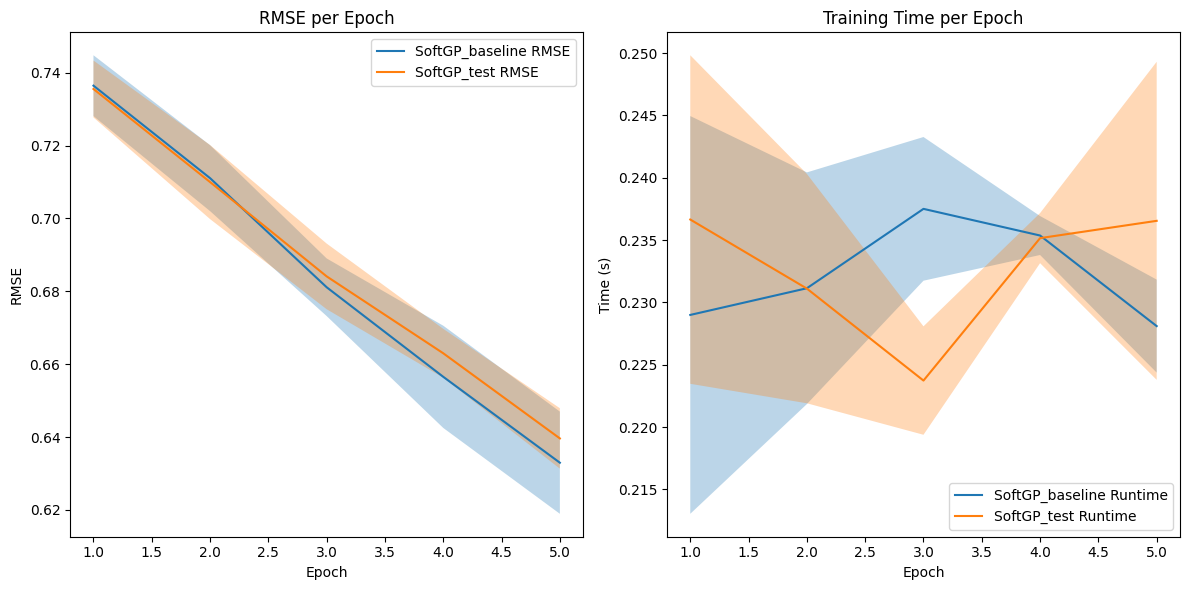

In [25]:
def plot_results(GP_classes, all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, GP_class in enumerate(GP_classes):
        epochs_range = range(1, epochs + 1)
        axes[0].plot(epochs_range, all_mean_rmse[i], label=f'{GP_class.__name__} RMSE')
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)
    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    for i, GP_class in enumerate(GP_classes):
        epochs_range = range(1, epochs + 1)
        axes[1].plot(epochs_range, all_mean_runtimes[i], label=f'{GP_class.__name__} Runtime')
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)
    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype):
    kernel = RBFKernel().to(device=device, dtype=dtype)
    learn_noise = False
    lr = .01
    batch_size = 64

    model = GP_class(kernel,
                     inducing_points,
                     noise=1e-3,
                     learn_noise=learn_noise,
                     use_scale=False,
                     dtype=dtype,
                     solver="solve",
                     max_cg_iter=50,
                     cg_tolerance=0.5,
                     mll_approx="exact",
                     fit_chunk_size=1024,
                     use_qr=False)

    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def train_model():
        #==================Train============================
        for epoch in range(epochs):
            epoch_start_time = time.time()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
                # pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
                # pbar.set_postfix(MLL=f"{-neg_mll.item()}")

            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
    
    train_model()
    return epoch_rmse, epoch_runtimes

def benchmark(GP_classes, train_dataset, test_dataset, epochs=2, seed=42, N=3):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 64
    dtype = torch.float32
    device = "cpu"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    for GP_class in GP_classes:
        print(f"Training {GP_class.__name__}...")
        
        # Run the experiment N times and store results for each run
        all_runs_rmse = []
        all_runs_runtimes = []
        
        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                GP_class,
                inducing_points.clone(),
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Dataset============================
from data.get_uci import ElevatorsDataset
dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=1/10,
    val_frac=8/10 #intentionally using small train test 
)

#==================Benchmark============================
GP_classes = [SoftGP_baseline, SoftGP_test] 
epochs = 5
N = 3  # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(GP_classes, train_dataset, test_dataset, epochs=epochs, seed=42, N=N)
plot_results(GP_classes, all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs)
